In [30]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [31]:
df=pd.read_csv("data.csv")
del df['Unnamed: 0']

In [32]:
df

,image,disease_type
0,dataset\glaucoma\1020_left.jpg,0
1,dataset\glaucoma\1209_left.jpg,0
2,dataset\glaucoma\1209_right.jpg,0
3,dataset\glaucoma\1210_left.jpg,0
4,dataset\glaucoma\1210_right.jpg,0
...,...,...
4212,dataset\diabetic_retinopathy\129_right.jpeg,3
4213,dataset\diabetic_retinopathy\1302_left.jpeg,3
4214,dataset\diabetic_retinopathy\1302_right.jpeg,3
4215,dataset\diabetic_retinopathy\1305_left.jpeg,3


In [33]:
import torch
import pandas as pd
from PIL import Image
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Создаем класс для нашего пользовательского датасета
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Преобразования изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Размер, подходящий для вашей модели
    transforms.ToTensor(),           # Преобразование изображений в тензоры
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

# Создаем объект нашего пользовательского датасета
custom_dataset = CustomDataset(dataframe=df, transform=transform)

# Создаем загрузчик данных
batch_size = 32
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

In [34]:
data_loader

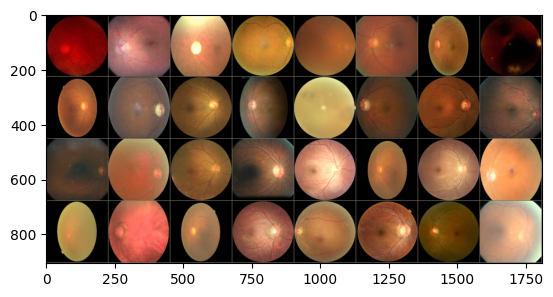

tensor(1) tensor(3) tensor(0) tensor(2) tensor(1) tensor(3) tensor(0) tensor(0) tensor(0) tensor(0) tensor(2) tensor(0) tensor(1) tensor(2) tensor(2) tensor(3) tensor(3) tensor(1) tensor(2) tensor(3) tensor(2) tensor(1) tensor(2) tensor(0) tensor(1) tensor(1) tensor(0) tensor(2) tensor(2) tensor(3) tensor(2) tensor(3)
torch.Size([32, 3, 224, 224])
disease_type
3    1098
2    1074
1    1038
0    1007
Name: count, dtype: int64


In [35]:
import matplotlib.pyplot as plt
import torchvision
# Визуализация нескольких изображений
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# Получаем случайный батч данных
images, labels = next(iter(data_loader))

# Выводим изображения и их метки
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

# Проверяем размер изображений
print(images.shape)

# Подсчитываем количество изображений в каждом классе
class_counts = df['disease_type'].value_counts()
print(class_counts)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import pandas as pd
import time
import copy

# Определяем модель ShuffleNet2
class ShuffleBlock(nn.Module):
    def __init__(self, in_c, out_c, downsample=False):
        super(ShuffleBlock, self).__init__()
        if downsample:
            stride = 2
        else:
            stride = 1
        
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_c, in_c, 3, stride, 1, groups=in_c, bias=False),
            nn.BatchNorm2d(in_c),
            nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, stride, 1, groups=out_c, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Conv2d(out_c, out_c, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out = torch.cat((out1, out2), 1)
        out = channel_shuffle(out, 2)
        return out

def channel_shuffle(x, groups):
    batch_size, channels, w, h = x.shape
    group_c = channels // groups
    x = x.view(batch_size, groups, group_c, w, h)
    x = x.transpose(1, 2).contiguous()
    x = x.view(batch_size, -1, w, h)
    return x

class ShuffleNet2(nn.Module):
    def __init__(self, num_classes=4):  # Здесь 4 - количество классов в вашем наборе данных
        super(ShuffleNet2, self).__init__()
        self.conv1 = nn.Conv2d(116, 24, 3, 1, 1)  # Изменяем количество входных каналов на 116
        self.maxpool = nn.MaxPool2d(3, 2, 1)  # Оставляем параметры субдискретизации без изменений

        self.stage2 = self._make_stage(24, 116, 4)
        self.stage3 = self._make_stage(116, 232, 8)
        self.stage4 = self._make_stage(232, 464, 4)
        self.conv5 = nn.Sequential(
            nn.Conv2d(464, 1024, 1, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def _make_stage(self, in_c, out_c, repeat):
        layers = []
        layers.append(ShuffleBlock(in_c, out_c, downsample=True))
        for _ in range(1, repeat):
            layers.append(ShuffleBlock(out_c, out_c, downsample=False))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Создаем модель
model = ShuffleNet2()

# Устройство для обучения (GPU если доступен, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем функцию потерь и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)


In [37]:
# Обучаем модель
def train_model(model, dataloader, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ["train"]:
            running_loss = 0.
            running_corrects = 0.
            model.train()
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print("Epoch {}/{} Loss: {:.4f} Acc: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

# Обучаем модель
num_epochs = 5
model = train_model(model, train_loader, loss_fn, optimizer, num_epochs=num_epochs)

# Сохраняем лучшую модель
torch.save(model.state_dict(), "./save/" + str(int(time.time())) + '.pkl')


RuntimeError: Given groups=1, weight of size [24, 116, 3, 3], expected input[32, 3, 224, 224] to have 116 channels, but got 3 channels instead